# Custom Loss functions

> ِAny custom losses should be here


In [ ]:
#| default_exp losses

In [ ]:
#| hide
from nbdev.showdoc import *  # type: ignore # noqa: F403

In [ ]:
#| export
import copy
import numpy as np
import torch, os, random
import torch.nn as nn
import torch.nn.functional as F
from fastcore.utils import * # type: ignore # noqa: F403


In [ ]:
#| export
class AnchorLoss(nn.Module):
    def __init__(self, num_classes, feature_num):
        super().__init__()
        self.num_classes = num_classes
        self.feature_num = feature_num

        self.anchor = nn.Parameter(F.normalize(torch.randn(num_classes, feature_num)), requires_grad=True)

    

In [ ]:
#| export
@patch
def forward(self: AnchorLoss, feature, _target, Lambda = 0.1):
    # broadcast feature anchors for all inputs
    centre = self.anchor.cuda().index_select(dim=0, index=_target.long())
    # compute the number of samples in each class
    counter = torch.histc(_target, bins=self.num_classes, min=0, max=self.num_classes-1)
    count = counter[_target.long()]
    centre_dis = feature - centre				# compute distance between input and anchors
    pow_ = torch.pow(centre_dis, 2)				# squre
    sum_1 = torch.sum(pow_, dim=1)				# sum all distance
    dis_ = torch.div(sum_1, count.float())		# mean by class
    sum_2 = torch.sum(dis_)/self.num_classes						# mean loss
    res = Lambda*sum_2   							# time hyperparameter lambda 
    return res

In [ ]:
#| hide
import torch
_target = torch.randint(0, 3, (32,)) # B = 32
labels = _target.type(torch.LongTensor)
labels

tensor([1, 2, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 1, 0, 0, 0,
        1, 2, 2, 1, 2, 0, 0, 2])

In [ ]:
ys = labels.float()
ys

tensor([1., 2., 0., 0., 1., 0., 2., 1., 2., 0., 2., 0., 0., 2., 2., 1., 1., 2.,
        2., 0., 1., 0., 0., 0., 1., 2., 2., 1., 2., 0., 0., 2.])

In [ ]:
anchor = torch.nn.Parameter(torch.randn(3, 512))

In [ ]:
centre = anchor.index_select(dim=0, index=ys.long())
centre.shape

torch.Size([32, 512])

In [ ]:
counter = torch.histc(ys, bins= 3, min=0, max=3-1)
counter

tensor([12.,  8., 12.])

In [ ]:
count = counter[ys.long()]
count

tensor([ 8., 12., 12., 12.,  8., 12., 12.,  8., 12., 12., 12., 12., 12., 12.,
        12.,  8.,  8., 12., 12., 12.,  8., 12., 12., 12.,  8., 12., 12.,  8.,
        12., 12., 12., 12.])

In [ ]:
feature = torch.randn(32, 512)
centre_dis = feature - centre	
centre_dis.shape

torch.Size([32, 512])

In [ ]:
ys = labels.float()
cls_num = 10
counter = torch.histc(ys, bins=cls_num, min=0, max=cls_num-1)
count = counter[_target.long()]

In [ ]:
count = counter[ys.long()]
count

tensor([4., 3., 4., 6., 1., 4., 4., 6., 3., 2., 6., 6., 2., 6., 4., 4., 3., 6.,
        6., 4., 1., 3., 2., 6., 6., 2., 6., 3., 3., 4., 6., 6.])

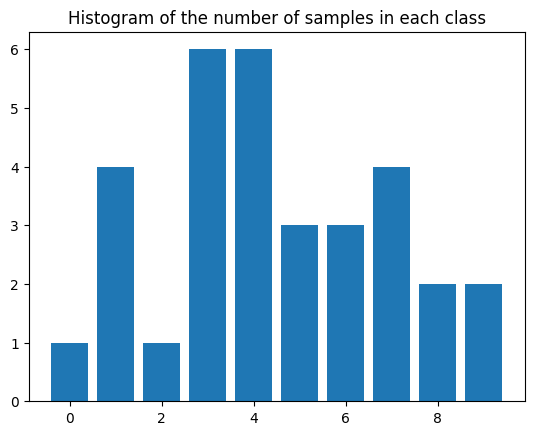

In [ ]:
#| hide
# visualise the counter as a histogram
import matplotlib.pyplot as plt
plt.bar(range(cls_num), counter)
plt.title('Histogram of the number of samples in each class')
plt.show()


In [ ]:
#| hide
import nbdev
nbdev.nbdev_export()